**Sterling Jones, Brendan Zytowski, Steven Alvarez**

Brendan and Sterling wrote first drafts of the Exploratory Analysis and Modeling parts and Steven improved upon these drafts by proofreading, optimizing, adding, removing, and rewriting code as necessary.  Steven also wrote the Discussion.

The goal of this project is to explore the Penguins dataset and with the fewest number of features, achieve the highest accuracy when classifying the penguins by species. To do this we are focusing on three different models: Multinomial Logistic Regression, Support Vector Machine, and a Decision Tree. 


###Exploratory Analysis

In [ ]:
# Needed packages and functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import urllib.request
from sklearn import preprocessing, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [ ]:
# Reading in the data

def retrieve_data(url):
  filedata = urllib.request.urlopen(url)
  to_write = filedata.read()
  with open('data.csv', 'wb') as f:
    f.write(to_write)

retrieve_data("https://philchodrow.github.io/PIC16A/content/IO_and_modules/IO/palmer_penguins.csv")
penguins = pd.read_csv('data.csv')

# there is only one region, so we can remove this column
penguins = penguins.drop(["Region"], axis = 1)

In [ ]:
# split the data into train and test data, then encode the textual
# data into integers
# seed to replicate results
np.random.seed(1287)
train, test = train_test_split(penguins, test_size = 0.2)

def prep_data(data_df, cols):
  """
  This function cleans up the data by encoding textual data
  into integer data and removing the target column from
  the predictor variable columns. This function then 
  returns the predictor and target variables as a tuple.
  """
  df = data_df.copy()
  try:
    df = (df[cols].dropna()).drop(336, axis=0)
  except KeyError:
    df = df[cols].dropna()
  le = preprocessing.LabelEncoder()
  df['Species'] = le.fit_transform(df['Species'])
  try:
    df['Sex'] = le.fit_transform(df['Sex'])
  except KeyError:
    pass
  try:
    df['Island'] = le.fit_transform(df['Island'])
  except KeyError:
    pass
  # Leaving this here because this info comes in handy for confusion matrix
  # 0 is Adelie, 1 is Chinstrap, 2 is Gentoo

  # remove Species from our predictor variable
  X = df.drop(["Species"], axis = 1)

  # extract only the Species column for our target variable
  y = df["Species"]

  return (X, y)

columns = ["Species", "Island", "Culmen Length (mm)", "Culmen Depth (mm)", 
           "Flipper Length (mm)", "Body Mass (g)", "Sex", 
           "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
X_train, y_train = prep_data(train, columns)
X_test, y_test = prep_data(test, columns)

First after we retrieved the data we cleaned it by removing both the region column and row 336 (due to having incomplete data). Next, we prepped the data by encoding the strings as integers to help our machine learning models understand them as categories. After this, we split the data into training and testing data so that we can train our models and test them on unseen data. We seperated the predictor variables and target variables into X and y respectively. We are going to try to achieve the highest accuracy possible by using only 2 features as opposed to 3 or more.

In [ ]:
# Feature Selection
# NOTE: this step should be performed separately for each model we use
# as each model will most likely perform better when specific columns 

def check_column_score(cols, c):
  """
  Trains and evaluates a model via 10-fold cross_validation on the columns of the
  data with selected indices
  """
  # Set multi_class parameter to multinomial for multinomial logistic regression
  if type(c).__name__ == 'LogisticRegression':
    m = LogisticRegression(multi_class='multinomial', max_iter = 1000)
  if type(c).__name__ == 'SVC':
    m = SVC(gamma = 0.2)
  if type(c).__name__ == 'DecisionTreeClassifier':
    m = tree.DecisionTreeClassifier(max_depth = 3)
  return cross_val_score(m, X_train[cols], y_train, cv = 10).mean()

columns = ["Island", "Culmen Length (mm)", "Culmen Depth (mm)", 
           "Flipper Length (mm)", "Body Mass (g)", "Sex", 
           "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]

# combinations of 2 attributes
combos = list(combinations(columns, 2))
combos = np.asarray(combos)

The three machine learning models we will be using are decision trees, multinomial logistic regression, and support vector classifiers.  All three of these models can be used to predict multiple target variables based on training data.  SVC creates decision boundaries from which the target variables can be classified.  Logistic regression makes predictions based on relationships between the predictor and target variables.  Decision trees deduce the target variable, in this case, the species of a penguin, based on decision rules which are gathered from the data. The below is an example of how a decision tree deduces the species of a penguin based on data of its characteristics.

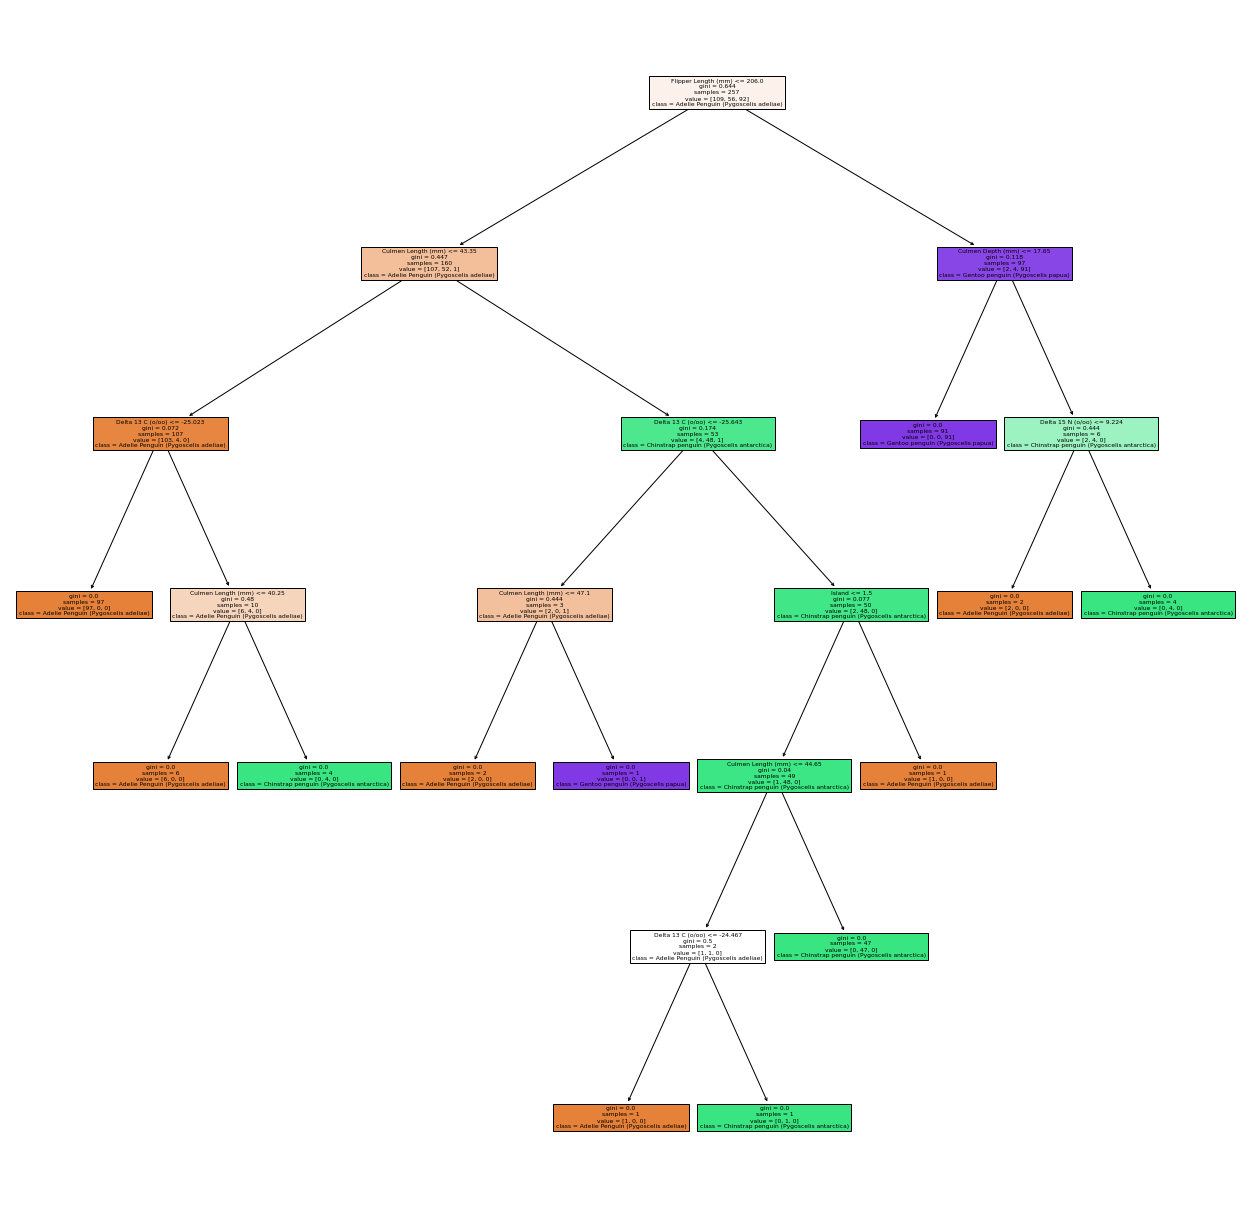

In [ ]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
fig, ax = plt.subplots(1, figsize=(22,22))
ax = tree.plot_tree(dt, feature_names = columns, class_names = penguins['Species'].unique(), filled=True)

To find which columns will work best for our machine learning models, we created a function to try every combination of 2 features to find the best one. This function determines which combination is the best by using the cross_val_score function. Cross_val_score splits the data into a specified number of sections and trains on all of them but one, then it will test on that last section of data. It will then iterate over these sections and train/test on the different combinations. This is a good way to validate the accuracy of our model without using the test data. We are expecting that different models may have different columns that work best for that model, so we are running this for each model.

In [ ]:
def best_mscore(combos, c):
  """
  This function takes in an array of combinations of
  columns from a train data set and finds the best feature
  combination that yields the highest score in a simple
  logistic regression model with 1000 iterations.
  The output is a tuple of the best score
  and the combination of features that yielded that score.
  """
  best_score = 0
  best_combo = []

  # iterate over the list of feature combinations
  for combo in combos:
    x = check_column_score(combo, c)

    # update the best score and the best combination
    if x > best_score:
      best_score = x
      best_combo = combo

  return (best_score, best_combo)
# best score and columns for all 3 models
print("Multinomial Logistic Regression: ", best_mscore(combos, LogisticRegression()))
print("Support Vector Machine ", best_mscore(combos, SVC()))
print("Decision Tree: ", best_mscore(combos, tree.DecisionTreeClassifier()))

Multinomial Logistic Regression:  (0.9495384615384616, array(['Culmen Length (mm)', 'Culmen Depth (mm)'], dtype='<U19'))
Support Vector Machine  (0.9496923076923078, array(['Culmen Length (mm)', 'Culmen Depth (mm)'], dtype='<U19'))
Decision Tree:  (0.9652307692307694, array(['Island', 'Culmen Length (mm)'], dtype='<U19'))


This function uses the check_column_score function from above to find which columns work best. As expected, we have a slight difference and not every model has the exact same optimal features. For Multinomial logistic regression our best features are Culmen Length and Culmen Depth with a score of 95%. For Support Vector Machine our best features are also Culmen Length and Culmen Depth with a score of 94.9%. For Decision Tree our best features are Island and Culmen Length with a score of 96.5%.

Text(0.5, 1.0, 'Scatter plot of Culmen Length, Culmen Depth, and Species')

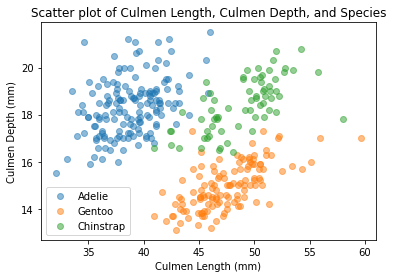

In [ ]:
fig, ax = plt.subplots(1)
ax.set(xlabel = "Culmen Length (mm)",
ylabel = "Culmen Depth (mm)")
species = penguins["Species"]
species = set(species)
culmenl = penguins["Culmen Length (mm)"]
culmend = penguins["Culmen Depth (mm)"]
for i in species:
  label = i.split()[0]
  culmen_length = penguins[penguins["Species"] == i]["Culmen Length (mm)"]
  culmen_depth = penguins[penguins["Species"] == i]["Culmen Depth (mm)"]
  ax.scatter(culmen_length, culmen_depth, label = label, alpha = .5)
ax.legend()
ax.set_title("Scatter plot of Culmen Length, Culmen Depth, and Species")

After our best_mscore function found that Culmen Length and Culmen Depth are the best two features for two of our models, we decided to visualize their relationship and species. As you can see in our scatter plot, there are three distinct clusters of data which indicates that there is a clear seperation in our data based on these features. It seems Adelie tend to have shorter culmens but greater depth. Chinstrap tend to have longer culmens with higher depth. Finally, Gentoo tend to have medium-longer culmens with lower depth.

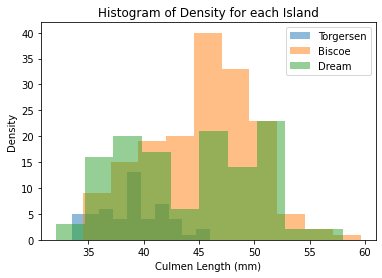

In [ ]:
fig, ax = plt.subplots(1)
island = penguins["Island"]
island = set(island)
culmenl = penguins["Culmen Length (mm)"]
for i in island:
  label = i.split()[0]
  culmen_length = penguins[penguins["Island"] == i]["Culmen Length (mm)"]
  nas = culmen_length.isna()
  culmen_length = culmen_length[np.invert(nas)]
  ax.hist(culmen_length, label = label, alpha = .5)
  ax.legend()
  ax.set(xlabel = "Culmen Length (mm)", ylabel = "Density")
  ax.set_title("Histogram of Density for each Island")

We decided to plot Island and Culmen length due to our function stating this is the optimal combination for a decision tree. This plot represents the density of specific culmen lengths by island. It appears that penguins on Biscoe tend to have high culmen lengths, suggesting that the population consists of a lot of Gentoo and Chinstrap. This also shows that the island of Dream appears to have a mixture of the three penguin species due to how spread out their histogram is. Finally, the island of Torgersen looks to have mainly Adelie due to the low density and low culmen length.

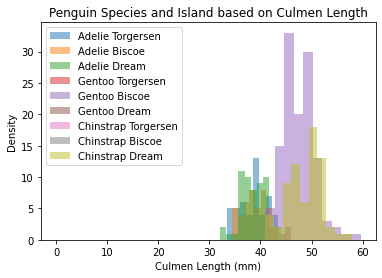

In [ ]:
fig, ax = plt.subplots(1)
species = penguins["Species"]
species = set(species)
island = penguins["Island"]
island = set(island)
culmenl = penguins["Culmen Length (mm)"]
culmend = penguins["Culmen Depth (mm)"]
for i in species:
  for j in island:
    label = i.split()[0] + " " + j.split()[0]
    culmen_length = penguins[(penguins["Species"] == i) & (penguins["Island"] == j)]["Culmen Length (mm)"]
    nas = culmen_length.isna()
    culmen_length = culmen_length[np.invert(nas)]
    ax.hist(culmen_length, label = label, alpha = .5)
    ax.legend()
    ax.set(xlabel = "Culmen Length (mm)", ylabel = "Density")
    ax.set_title("Penguin Species and Island based on Culmen Length")

We wanted to further explore the relationship of Island and Culmen Length so we decided to plot the Island along with the species of each penguin on those islands. We are seeing similar results to the previous graph and this confirms our suspicions of which species are on which islands. There appears to be many more Gentoo on Biscoe compared to any other species/island combo.




In [ ]:
# Create a dataframe with these columns and display statistics by species and island.
penguins_visual = penguins[["Culmen Depth (mm)", "Culmen Length (mm)", "Island", "Species"]]
penguins_visual.groupby(["Species", "Island"]).aggregate([np.mean, np.std])

Culmen Depth (mm)  ... Culmen Length (mm)
                                                                 mean  ...                std
Species                                   Island                       ...                   
Adelie Penguin (Pygoscelis adeliae)       Biscoe            18.370455  ...           2.480916
                                          Dream             18.251786  ...           2.465359
                                          Torgersen         18.429412  ...           3.025318
Chinstrap penguin (Pygoscelis antarctica) Dream             18.420588  ...           3.339256
Gentoo penguin (Pygoscelis papua)         Biscoe            14.982114  ...           3.081857

[5 rows x 4 columns]

Visually, we have a good understanding of how our models should perform so we wanted to look at the actual data to see how similar the numbers are. We can see that Adelie are found on all three islands, but Chinstrap and Gentoo are only found on one island each. This seems like a very important distinction and must be why Island is a good feature for classifying species, especially for decision trees. We can also see that there is some overlap between the Culmen Depth for Adelie on Torgerson Island and Chinstrap on Dream Island. Additionally, there is overlap for Culmen Length for Gento on Biscoe Island and Chinstrap on Dream Island. These are reasons why our model may have some difficulty classifying these species using these features.

### Modeling

In [ ]:
# First, subset each train and test set with our preferred features
columns = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Species']
columnsT = ['Island', 'Culmen Length (mm)', 'Species']
X_train, y_train = prep_data(train, columns)
X_test,  y_test  = prep_data(test, columns)
# These are the train, test sets for the DecisionTree model
X_trainT, y_trainT = prep_data(train, columnsT)
X_testT, y_testT = prep_data(test, columnsT)

Here we are reinitializing our data using our preferred features and the target variable. We split the training data and testing data with a ratio of 80/20 respectively. Then, we print out a sample of the X testing and y testing data to make sure this is the correct data.

In [ ]:
def cross_val(model_name):
  """
  This is a function that takes in model_name as an input and finds the optimal complexity parameter for each model 
  based on the name we input. This is done by iterating and increasing the complexity parameter while saving the best parameter and score pair.
  Input: model_name (string)
  Return best complexity for our input model
  """
  # Create a subplot to visualize our results
  fig, ax = plt.subplots(1)
  # Initialize our score/complexity pair
  best_score = 0
  best_complexity = 0
  # Check which model it is by checking input string
  if model_name == 'LogisticRegression':
    # Iterate 100 times from .1 to 10 and increasing the complexity 
    for d in np.linspace(.1, 10, 100):
      # Create the model
      L = LogisticRegression(C = d, multi_class='multinomial', max_iter = 1000)
      # Get the mean of the cross_val_score function 
      cv_score = cross_val_score(L, X_train, y_train, cv = 10).mean()
      # Plot the score on our subplot for this model
      ax.scatter(d, cv_score, color = "blue")
      # Test to make sure we capture the best score
      if cv_score > best_score:
        best_score = cv_score
        best_complexity = d
  # This is if our string is SVC for support vector machine model
  elif model_name == 'SVC':
    # Iterate 100 times from .1 to 10 and increasing the complexity 
    for d in np.linspace(.1, 10, 100):
      # Initialize our SVC model
        S = SVC(gamma = d)
        # Get the mean of the cross_val_score function 
        cv_score = cross_val_score(S, X_train, y_train, cv = 10).mean()
        # Plot the score on our subplot for this model
        ax.scatter(d, cv_score, color = "blue")
        # Test to make sure we capture the best score
        if cv_score > best_score:
          best_score = cv_score
          best_complexity = d
  else:
    # Else if this is the last type of model (decision tree) 
    for d in np.linspace(1, 10, 10):
      # Initialize our model
      T = tree.DecisionTreeClassifier(max_depth = d)
      # Get the mean of the cross_val_score function 
      cv_score = cross_val_score(T, X_trainT, y_trainT, cv = 10).mean()
      # Plot the score on our subplot for this model
      ax.scatter(d, cv_score, color = "blue")
      # Test to make sure we capture the best score
      if cv_score > best_score:
        best_score = cv_score
        best_complexity = d
  # Set titles for plot
  l = ax.set(title = "Best Complexity Parameter for " + str(model_name) + ": " + str(best_complexity.round(2)),
            xlabel = "Complexity Parameter",
            ylabel = "CV Score")
  return best_complexity

This is a function that takes in a string name of the models we are testing. Depending on which string is input, this function will use cross validation to find the optimal complexity for each model and then plot the scores. By using this, we can find the best complexity parameter for each of our models.


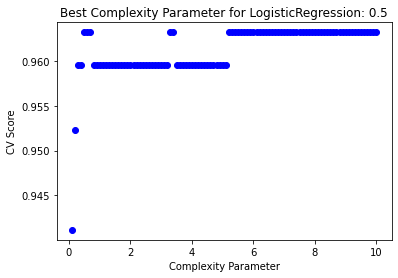

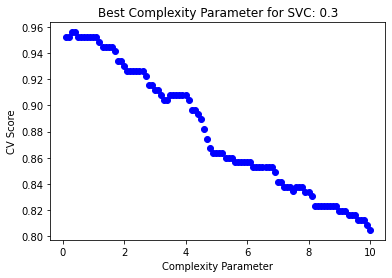

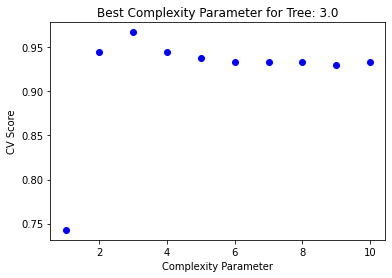

In [ ]:
best_L = cross_val("LogisticRegression")
best_S = cross_val("SVC")
best_T = cross_val("Tree")

Based on these above plots, we can see each of the iterations of our complexity parameters and see which one achieved the highest CV score so that we can use that parameter.

In [ ]:
L = LogisticRegression(C = best_L, multi_class='multinomial', max_iter = 1000)
svc = SVC(gamma = best_S)
dt = tree.DecisionTreeClassifier(max_depth = best_T)
L.fit(X_train, y_train)
svc.fit(X_train, y_train)
dt.fit(X_trainT, y_trainT)
L.score(X_train, y_train), svc.score(X_train, y_train), dt.score(X_trainT, y_trainT)

(0.9595588235294118, 0.9779411764705882, 0.9705882352941176)

 Greater than 95% is pretty great for our all three of our models using only two features. 

Let's see how this model will perform on the training data so we can compare the testing vs training accuracy. 

In [ ]:
L.score(X_test, y_test), svc.score(X_test, y_test), dt.score(X_testT, y_testT)

(0.9855072463768116, 0.9710144927536232, 0.9855072463768116)

So our model performed a bit differently on the training data than our testing data, but still gets high accuracy on the test data sets. Let's examine the decision region of our models to visualize where our model made the errors.

In [ ]:

def plot_regions(c, X, y, columns, title):
    """
    Plots the decision regions from a classifer 
    underneath the data in X and y. 
    c: a classifier
    X: predictor variables
    y: target variables
    columns: list of strings that are column names
    """
    # for convenience, give names to the two 
    # columns of the data
    x0 = X[columns[0]]
    x1 = X[columns[1]]
    
    # create a grid
    grid_x = np.linspace(x0.min(), x0.max(), 501)
    grid_y = np.linspace(x1.min(), x1.max(), 501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    # extract model predictions, using the 
    # np.c_ attribute to join together the 
    # two parts of the grid. 
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p 
    # back into 2d
    p = c.predict(np.c_[xx.ravel(), yy.ravel()])
    p = p.reshape(xx.shape)
    # create the plot
    fig, ax = plt.subplots(1)
    # use contour plot to visualize the predictions
    ax.contourf(xx, yy, p, cmap = "jet", alpha = 0.2)
    # plot the data
    ax.scatter(x0, x1, c = y, cmap = "jet")
    
    ax.set(xlabel = columns[0],
           ylabel = columns[1])
    ax.set_title(title)



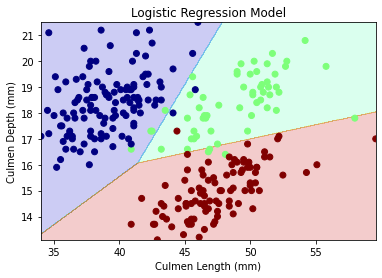

In [ ]:
title = "Logistic Regression Model"
plot_regions(L, X_train, y_train, columns, title)

Based on the plot above we can see how our model classifies the penguin species based on Culmen Length and Culmen Depth. Near the middle of the plot there are some classification errors but for the most part, there are distinct regions that correctly classify the penguins. 

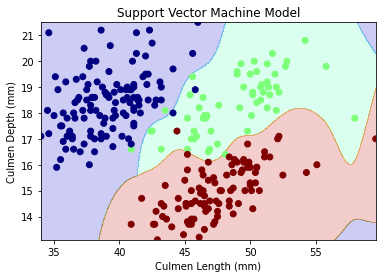

In [ ]:
title = "Support Vector Machine Model"
plot_regions(svc, X_train, y_train, columns, title)

While our Support Vector Machine was not our best performing model, we wanted to visualize the decision regions of this model to get an idea of how the data was classified.

Below we implement a confusion matrix for our Decision Tree model, which gives us an idea of where this model's predictions went wrong. What this matrix tells us is that our model predicted the i'th penguin when it was actually the j'th (i being row index and j being column index). Here the penguins are encoded as 0, 1, and 2, where 0 is Adelie, 1 is Chinstrap, and 2 is Gentoo.

In [ ]:
y_train_pred = dt.predict(X_trainT)
cm = confusion_matrix(y_trainT, y_train_pred)
cm

array([[115,   2,   3],
       [  1,  56,   0],
       [  2,   0,  93]])

In [ ]:
mistakes = X_trainT[y_trainT != y_train_pred]
mistake_labels = y_trainT[y_trainT != y_train_pred]
mistake_preds = y_train_pred[y_trainT != y_train_pred]

mistake_preds, mistake_labels

(array([2, 2, 2, 0, 0, 0, 1, 1]), 109    0
 111    0
 115    0
 182    1
 230    2
 326    2
 43     0
 99     0
 Name: Species, dtype: int64)

In [ ]:
print(penguins.loc[111][['Species', 'Island', 'Culmen Length (mm)']], penguins.loc[182][['Species', 'Island', 'Culmen Length (mm)']])

Species               Adelie Penguin (Pygoscelis adeliae)
Island                                             Biscoe
Culmen Length (mm)                                   45.6
Name: 111, dtype: object Species               Chinstrap penguin (Pygoscelis antarctica)
Island                                                    Dream
Culmen Length (mm)                                         40.9
Name: 182, dtype: object


These two wrongly predicted penguins have culmen lengths that significantly deviate from the average for their species on those particular islands.  The average culmen length for Adelies on Biscoe is 38.9mm and the average culmen lenth for Chinstraps on Cream is 48.8mm. This is perhaps why our decision tree made some incorrect predictions here.

### Discussion

Although all of our models performed well on the test data, we recommend the logistic regression model with the Culmen Depth and Culmen Length columns to reliably predict penguin species.  This model had the highest accuracy score on the test data and biggest improvement from train to test accuracy score.  We probably could have gotten higher accuracy using one more characteristic of the penguins such as sex but found it sufficient and more efficient to make our predictions using only two characteristics.  Although our model achieved high predictive accuracy, it was still not perfect and misclassified some penguins who had characteristics that significantly deviated from the average for their species.  This could be harmful if deciding where to place a lost penguin, as they could be placed among the wrong species and in the wrong environment.  Although all species of these penguins are well adapted to survive in the harsh climate of Antarctica, there may be subtle environmental differences in these Antarctic islands for which a misplaced penguin is not adapted.  Therefore care must be taken in classifying the penguins, perhaps using more data which is not in this set or using characteristics which are not so neatly classifiable into data sets, like behavioral patterns.  These could probably be discerned better by a human expert on the subject rather than by a machine learning model, although we imagine this is possible too.